### **Object Detection Using Faster RCNN**

***Importing Libraries***

In [ ]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, accuracy_score

***Setting T4 GPU***

In [ ]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


***Load and preprocess the dataset***

In [ ]:
# Step 2: Load and preprocess the MNIST dataset
# Load the MNIST dataset with transforms to convert to grayscale (3 channels) and resize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.05MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



***Quick Testing***

In [ ]:
# Select a smaller subset of the MNIST dataset for quick testing
num_images = 100
num_per_row = 4

mnist_images = [mnist_data[i][0] for i in range(num_images)]
mnist_labels = [mnist_data[i][1] for i in range(num_images)]

***Creating Bounding Boxes***

In [ ]:
# Step 4: Create stacked images and bounding boxes
image, label, bounding_boxes = [], [], []
image_size = 256  # Adjusted image size

for i in range(num_images):
    indices = random.sample(range(len(mnist_images)), num_per_row)
    row = torch.cat([mnist_images[idx] for idx in indices], dim=2)
    image.append(row)
    label.append([mnist_labels[idx] for idx in indices])

    # Define bounding boxes for each image in the row
    row_bboxes = []
    for col_idx in range(num_per_row):
        x_min = col_idx * image_size
        y_min = 0
        x_max = x_min + image_size
        y_max = y_min + image_size
        row_bboxes.append([x_min, y_min, x_max, y_max])
    bounding_boxes.append(row_bboxes)


***Visualizing Images***

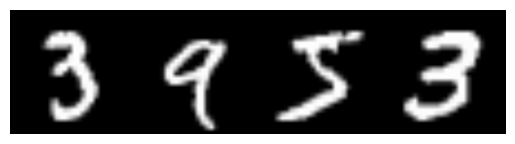

In [ ]:
# Convert one row to PIL image and visualize it
stacked_pil = transforms.ToPILImage()(image[0])
plt.imshow(stacked_pil)
plt.axis('off')
plt.show()

***Custom Dataset Class***

In [ ]:
# Custom Dataset Class
class mnist_Data(Dataset):
    def __init__(self, image, label, bounding_boxes, device):
        self.image = image
        self.label = label
        self.bounding_boxes = bounding_boxes
        self.device = device

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        target = {
            "boxes": torch.as_tensor(self.bounding_boxes[idx], dtype=torch.float32),
            "labels": torch.as_tensor(self.label[idx], dtype=torch.int64)
        }
        img = img.to(self.device)
        target = {k: v.to(self.device) for k, v in target.items()}
        return img, target

***Preparing Dataloaders***

In [ ]:
# Prepare dataset and dataloaders
data = mnist_Data(image, label, bounding_boxes, device)
dataloader = DataLoader(data, batch_size=1, shuffle=True)

***Training for 5 epochs***

In [ ]:
# Load Faster R-CNN model (pre-trained ResNet-50 backbone with FPN)
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)  # Move model to GPU if available
model.train()  # Set the model to training mode

# Define optimizer and training parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5  # Train for 5 epochs initially
all_losses = []  # List to track losses

***Calculating Precision, Recall, Accuracy***

In [ ]:
# Training Loop with Metric Calculation
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    pred_labels = []

    for images, targets in dataloader:  # Iterate using dataloader
        images, targets = data[i]
        images = images.unsqueeze(0)  # Add batch dimension
        targets = [targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Extract predictions for metric calculation (within the loop)
        with torch.no_grad():
            model.eval()
            predictions = model(images)
            model.train()
            for i, prediction in enumerate(predictions):
                # Assuming only one object per image for simplicity
                pred_labels.append(prediction["labels"][0].cpu().item()) # Get the first prediction
                true_labels.append(targets[i]["labels"][0].cpu().item())


    # Calculate metrics for the epoch
    precision = precision_score(true_labels, pred_labels, average='micro')
    recall = recall_score(true_labels, pred_labels, average='micro')
    accuracy = accuracy_score(true_labels, pred_labels)

    # Log losses and metrics
    all_losses.append(epoch_loss)  # Appending the epoch loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/5], Total Loss: 24.5726, Precision: 0.7900, Recall: 0.7900, Accuracy: 0.7900
Epoch [2/5], Total Loss: 3.2521, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Epoch [3/5], Total Loss: 2.2063, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Epoch [4/5], Total Loss: 1.6882, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Epoch [5/5], Total Loss: 1.5162, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000


***Plotting Loss Values***

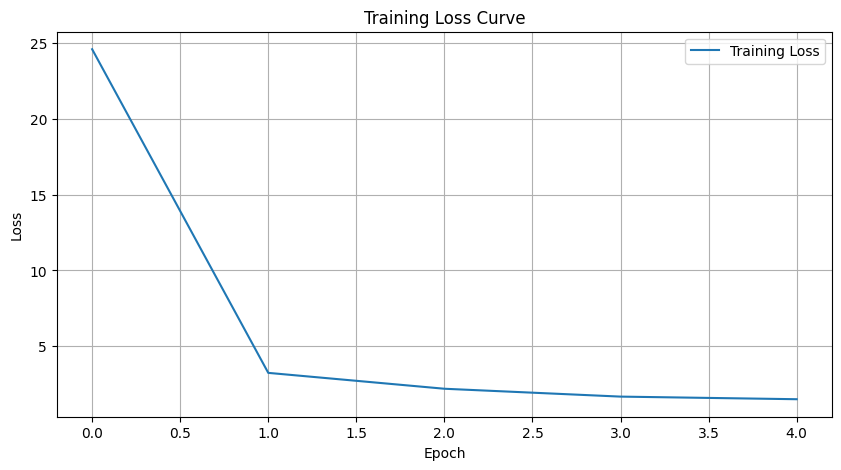

In [ ]:
# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

***Display the ground truth and predicted bounding boxes***

In [ ]:
# Function to visualize predictions
def plot_prediction(model, image, target):
    image = image.to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model([image])

    # Convert image tensor to PIL image for display
    image_pil = transforms.ToPILImage()(image.cpu())

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)

    # Display the ground truth bounding boxes
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)

    # Display the predicted bounding boxes
    top_4_indices = torch.argsort(prediction[0]['scores'], descending=True)[:4]
    for index in top_4_indices:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][index].tolist()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f"Label:{prediction[0]['labels'][index].item()}, Score:{prediction[0]['scores'][index].item():.2f}", color='r')

    plt.axis('off')
    plt.show()

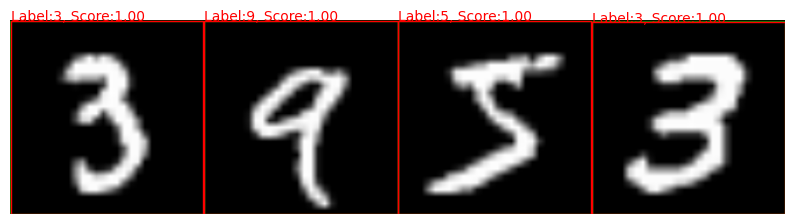

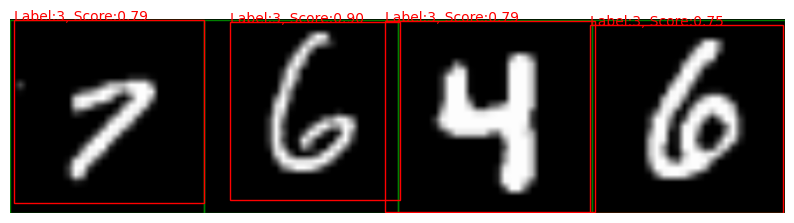

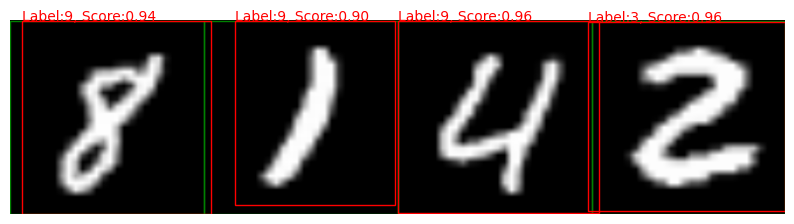

In [ ]:
# Test the model on the test dataset
for i in range(3):  # Display predictions for 3 samplesn\
    img, tgt = data[i]
    plot_prediction(model, img, tgt)